In [167]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, recall_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV



## Problem Statement

- Twitter is one of the fastest ways people in an emergency can communicate and share information. However, a lot of keywords used to describe an emergency are used in other, non-emergency situations. I will build a model that discerns the difference between human language describing real emergencies and non-emergencies in Tweets in order to help send aid as quickly as possible to those who are actually in danger.   


![An example of a non-emergency Tweet that uses the keyword 'Ablaze'](image1.PNG "An example of a non-emergency Tweet that uses the keyword 'Ablaze'")

## Data cleaning

In [108]:
train_df = pd.read_csv('./data/train.csv', index_col='id')
test_df = pd.read_csv('./data/test.csv', index_col='id')
train_df.tail()

,keyword,location,text,target
id,,,,
10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1
10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1
10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1
10872,NaN,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1
10873,NaN,NaN,The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d,1


In [27]:
train.shape, test.shape

((7613, 4), (3263, 3))

In [28]:
train.isna().sum()

keyword       61
location    2533
text           0
target         0
dtype: int64

**Because there are so many nulls in location, I dropped the column.**
**Also dropping keyword, because it had a few nulls and isn't needed for the model**

In [29]:
train = train.drop(columns=['location','keyword'])
train.head()

,text,target
id,,
1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
4,Forest fire near La Ronge Sask. Canada,1
5,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
6,"13,000 people receive #wildfires evacuation orders in California",1
7,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


**Repeat this for test data**

In [30]:
test.isna().sum()

keyword       26
location    1105
text           0
dtype: int64

In [159]:
test = test.drop(columns=['location','keyword'])
test.head()

,text
id,
0,Just happened a terrible car crash
2,"Heard about #earthquake is different cities, stay safe everyone."
3,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
9,Apocalypse lighting. #Spokane #wildfires
11,Typhoon Soudelor kills 28 in China and Taiwan


In [161]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 1 to 10873
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 178.4+ KB


## EDA

In [150]:
# set num=1 to look at individual words, num=2 to look at bigrams or num=3 to look at trigrams
# type = 'graph' or 'dataframe' depending on what output you want
# word_count = how many words (or bigrams/trigrams) you want to look at
    
def get_common_words(df, num, word_count):
    cv = CountVectorizer(stop_words='english', ngram_range=(num,num))
    data = pd.DataFrame(cv.fit_transform(df['text']).A, columns=cv.get_feature_names_out())    
    return data.sum().sort_values(ascending=False).head(15).plot(kind='barh');

### Common words where target=1 (disaster)

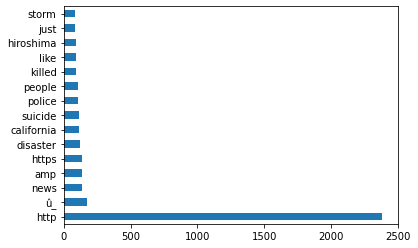

In [147]:
df_disasters = train[train['target']==1]

get_common_words(df_disasters, 1, 15);

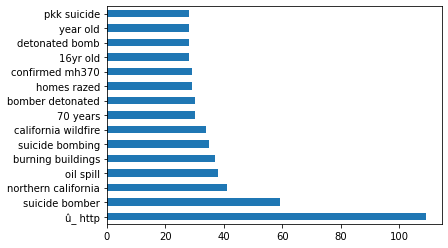

In [149]:
#graph bigrams and trigrams as well

get_common_words(df_disasters, 2, 15);

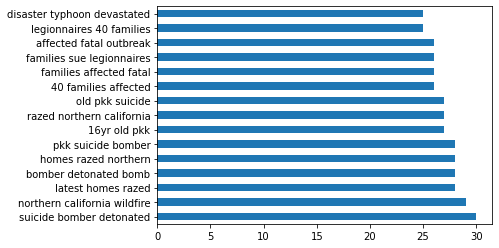

In [151]:
get_common_words(df_disasters, 3, 15);

### Common words where target=0 (non-disaster)

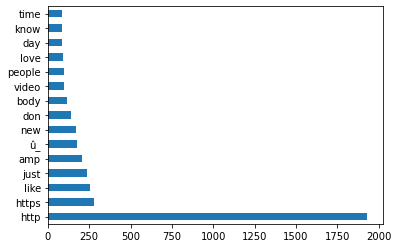

In [152]:
#graph common words where target=0
df_non_disasters = train[train['target']==0]

get_common_words(df_non_disasters, 1, 15);

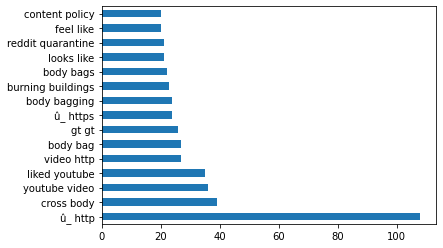

In [153]:
#graph common words where target=0
df_non_disasters = train[train['target']==0]

get_common_words(df_non_disasters, 2, 15);

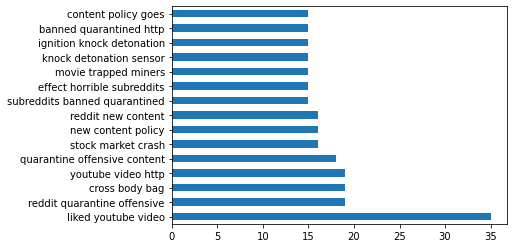

In [154]:
#graph common words where target=0
df_non_disasters = train[train['target']==0]

get_common_words(df_non_disasters, 3, 15);

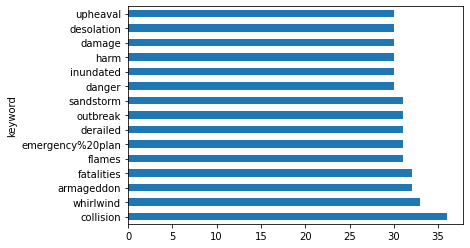

In [157]:
#look at common keywords 
train_df.groupby('keyword')['keyword'].count().sort_values(ascending=False).head(15).plot(kind='barh');

## Baseline Model

**1 is disaster, 0 is no disaster**

In [39]:
train['target'].value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

**Data is slightly imbalanced**

## Train/Test Split

**I'm going to ignore test.csv since it doesn't have the correct answers and train/test split train.csv.**

In [174]:
#train/test split
X = train['text']
y = train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

#vectorize the text
cv = CountVectorizer(stop_words='english')
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

X_train_cv = pd.DataFrame(X_train_cv.A, columns=cv.get_feature_names_out())
X_test_cv = pd.DataFrame(X_test_cv.A, columns=cv.get_feature_names_out())

## Models 

### 1) Logistic Regression Model

- This model had the best recall score

In [62]:
logreg = LogisticRegression()

logreg.fit(X_train_cv, y_train)
logreg.score(X_train_cv, y_train), logreg.score(X_test_cv, y_test)

(0.9709231038710807, 0.7914915966386554)

**Very overfit**

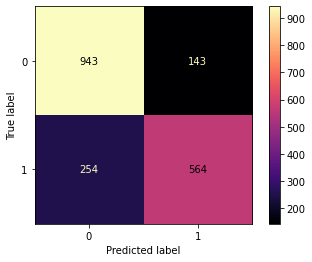

In [82]:
ConfusionMatrixDisplay.from_estimator(logreg, X_test_cv, y_test,  cmap='magma');

In [168]:
f1_score(y_test, logreg.predict(X_test_cv))

0.7396721311475409

In [169]:
recall_score(y_test, logreg.predict(X_test_cv))

0.6894865525672371

### 2) Random Forest Model

In [68]:
forest = RandomForestClassifier()

forest.fit(X_train_cv, y_train)
forest.score(X_train_cv, y_train), forest.score(X_test_cv, y_test)

(0.9966719215274129, 0.7804621848739496)

**How'd it do? Even more overfit!**

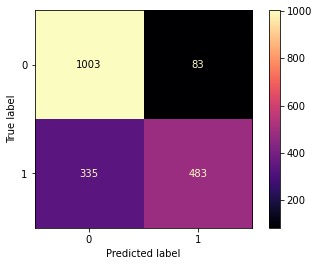

In [80]:
ConfusionMatrixDisplay.from_estimator(forest, X_test_cv, y_test,  cmap='magma');

In [170]:
f1_score(y_test, forest.predict(X_test_cv))

0.6979768786127167

In [172]:
recall_score(y_test, forest.predict(X_test_cv))

0.5904645476772616

**Random forest model looks like it is predicting everything as not a disaster which is not great.**

### 3) Ensemble Model

- This model had the best f1 score

In [182]:
vc = VotingClassifier([
    ('logreg', LogisticRegression(max_iter=10_000)),
    ('tree', RandomForestClassifier()),
    ('nb', MultinomialNB())
    ],
    voting='soft',
    weights=[.4,.3,.3],
    n_jobs=-1
)
vc.fit(X_train_cv, y_train)
vc.score(X_train_cv, y_train), vc.score(X_test_cv, y_test)

(0.9623401646523034, 0.8046218487394958)

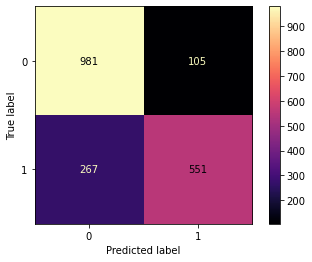

In [183]:
ConfusionMatrixDisplay.from_estimator(vc, X_test_cv, y_test,  cmap='magma');

In [184]:
f1_score(y_test, vc.predict(X_test_cv))

0.7476255088195386

In [185]:
recall_score(y_test, vc.predict(X_test_cv))

0.6735941320293398

### 4) RandomSearching

In [ ]:
#I tried running this a few times with different weights, different models, and different number of models. It didn't get any better

params =  {
    'weights' : [[.1,.9],[.2,.8],[.3,.7],[.4,.6],[.5,.5],[.6,.4],[.7,.3],[.8,.2],[.9,.1]],
    'voting' : ['hard','soft']}

rs= RandomizedSearchCV(VotingClassifier([
    ('logreg', LogisticRegression(max_iter=10_000)),
    ('nb', MultinomialNB())
    ]), params, n_jobs=-1)

rs.fit(X_train_cv, y_train)
rs.score(X_test_cv, y_test)

### 4) Ensemble Model 2

In [133]:
vc2 = VotingClassifier([
    ('logreg', LogisticRegression()),
    ('tree', RandomForestClassifier()),
    ('nb', GaussianNB())
    ],
    voting='soft',
    weights=[.4,.3,.3],
    n_jobs=-1
)
vc2.fit(X_train_cv, y_train)
vc2.score(X_train_cv, y_train), vc2.score(X_test_cv, y_test)

(0.9942196531791907, 0.7720588235294118)

## Try Lemmatization

In [ ]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemma_tokenizer(doc):
    wnl = WordNetLemmatizer()
    return [wnl.lemmatize(w) for w in word_tokenize(doc)]

cv2 = CountVectorizer(tokenizer=lemma_tokenizer, stop_words='english')
X_train_cv2 = cv2.fit_transform(X_train)
X_test_cv2 = cv2.transform(X_test)

X_train_cv2 = pd.DataFrame(X_train_cv2.A, columns=cv2.get_feature_names_out())
X_test_cv2 = pd.DataFrame(X_test_cv2.A, columns=cv2.get_feature_names_out())

### Plug that into best models

In [165]:
vc2 = VotingClassifier([
    ('logreg', LogisticRegression(max_iter=10_000)),
    ('tree', RandomForestClassifier()),
    ('nb', MultinomialNB())
    ],
    voting='hard',
    weights=[.4,.3,.3],
    n_jobs=-1
)
vc2.fit(X_train_cv2, y_train)
vc2.score(X_train_cv2, y_train), vc.score(X_test_cv2, y_test)

(0.9726747241198108, 0.7977941176470589)

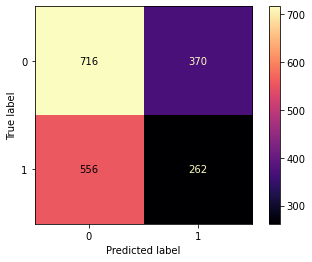

In [176]:
ConfusionMatrixDisplay.from_estimator(vc2, X_test_cv2, y_test,  cmap='magma');

In [178]:
f1_score(y_test, vc2.predict(X_test_cv2))

0.36137931034482756

In [187]:
recall_score(y_test, vc2.predict(X_test_cv2))

0.3202933985330073

In [190]:
logreg2 = LogisticRegression(max_iter=10_000)

logreg2.fit(X_train_cv2, y_train)
logreg2.score(X_train_cv2, y_train), logreg2.score(X_test_cv2, y_test)

(0.9563846558066211, 0.5194327731092437)

In [192]:
f1_score(y_test, logreg2.predict(X_test_cv2))

0.3676572218382861

In [194]:
recall_score(y_test, logreg2.predict(X_test_cv2))

0.3251833740831296

**Lemmatization is making the models predict more disasters as non-disasters which is not good**

## Analysis 

- My best model (if looking at f1 score) seems to be an ensemble model with Logisitic Regression, Random Tree, and Naive Bayes that has been count vectorized. 
- My best model (if looking at Recall Score/minimizing FN) is a logistic regression model that has been count vectorized
- Lemmatization did terribly
- It seems to misidentify diasasters as non-disasters more than it misidentifies non-disasters as disasters which is not great. 

## Conclusions and Next Steps 

- Look into misclassifications. Figure out what type of Tweet is getting misclassified the most
- Include 'http' as a stop word (and perhaps others)
- Find a model that misidentifies disasters as non-disasters less (even if it's at the expense of misclassifying non-disasters as disasters)
- Address overfitting